In [1]:
# Import the packages we will use
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas
import math

In [2]:
import sys
import os
sys.path.insert(0, os.getcwd().rsplit('/',1)[0])

import loops_utils

In [3]:
# The following directive activates inline plotting
%matplotlib inline

###### Select chromose to work with

In [4]:
chr = 1

### 10kb resolution

In [5]:
resolution = 10**4

In [6]:
arr = np.load('arrs/10kb_chr' + str(chr) + '.npy')
arr_log = np.load('arrs/10kb_chr' + str(chr) + '_log.npy')
arr_norm = np.load('arrs/10kb_chr' + str(chr) + '_norm.npy')
arr_norm_log = np.load('arrs/10kb_chr' + str(chr) + '_norm_log.npy')

###### Read loops coordinates, sizes and etc

In [7]:
loops_info = pandas.read_csv('GSE63525_GM12878_primary+replicate_HiCCUPS_looplist.txt', sep='\t',
                             dtype = {'x1': np.long, 'x2': np.long, 'y1': np.long, 'y2': np.long})
loops_info[['x1', 'x2', 'y1', 'y2', 'centroid1', 'centroid2', 'radius']] = loops_info[['x1', 'x2', 'y1', 'y2', 'centroid1', 'centroid2', 'radius']].apply(
    lambda x : (x / resolution).astype('int64')
)
loops = loops_info[loops_info.chr1 == str(chr)]

Normalized map was produced by function:
It divides each diagonal of a Hi-C contact map by its' mean.  
It also does it in a smart way: it calculates averages over stripes from X to X*1.05, and divides each stripe by its mean.  
It allows to avoid divergence far from the main diagonal with a very few reads.  
(comment from __mirnylib__)

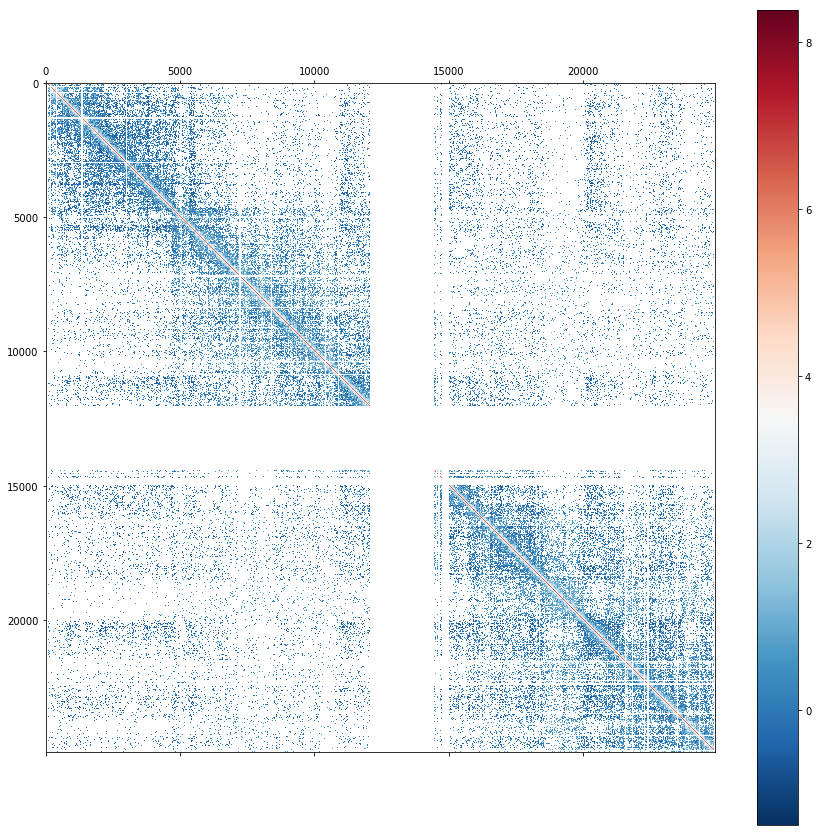

In [8]:
loops_utils.plot_HiC(arr_log, name = 'rao_hic_raw')

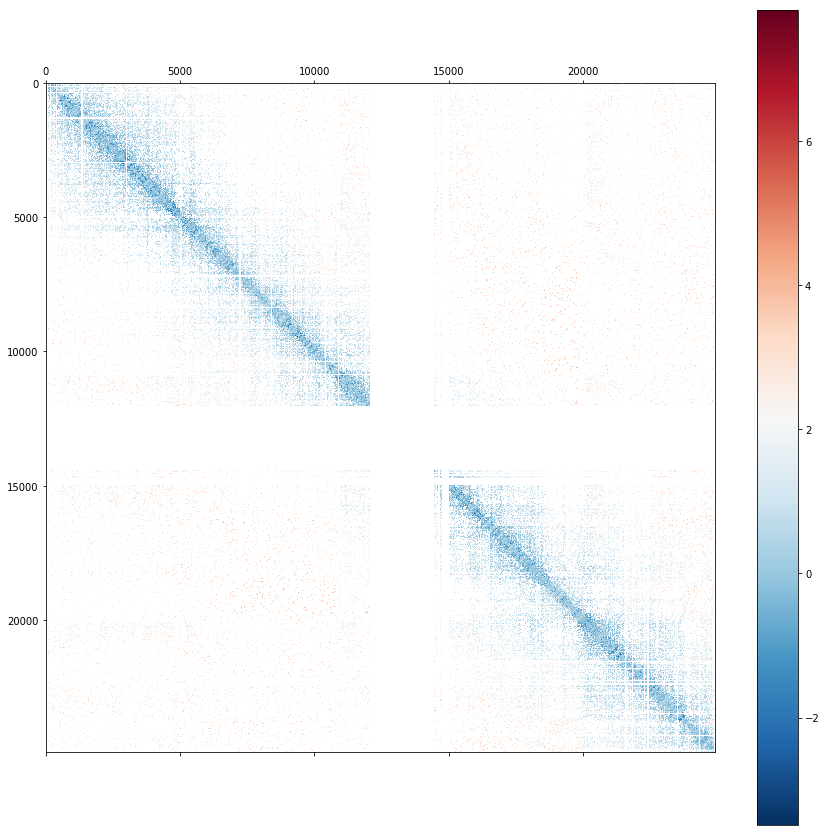

In [9]:
loops_utils.plot_HiC(arr_norm_log, name = 'rao_hic_norm')

#### Loops on Hi-C

In [10]:
def plot_loops_on_hic_matrix(arr, resolution, loops_info, start = 0, end = -1):     
    '''
        plot loops with boundaries on a HiC map
    '''
    ax = loops_utils.plot_HiC(arr[start:end, start:end])

    for index, row in loops_info.iterrows():

        x1, x2, y1, y2 = row[['x1', 'x2', 'y1', 'y2']] - start - 0.5

        loop_y_centroid = row['centroid1'] - start
        loop_x_centroid = row['centroid2'] - start
        loop_radius = row['radius']

        loop_center = (loop_x_centroid, loop_y_centroid)

        ## loop as a circle with center in @loop_center with radius @loop_radius
        loop = matplotlib.patches.Circle(loop_center, loop_radius,
                                         fill=None, alpha=1,
                                         edgecolor='lime', linewidth=2.0)
        ax.add_patch(loop)

        ## areas with start locus and end locus
        loop_tr = matplotlib.patches.Rectangle((x2, x1), y2-x2, y1-x1, 
                                               fill=None, alpha=1,
                                               edgecolor='black', linewidth=.5)
        ax.add_patch(loop_tr)
        
    plt.savefig('pictures/rao_loops_viz.png')

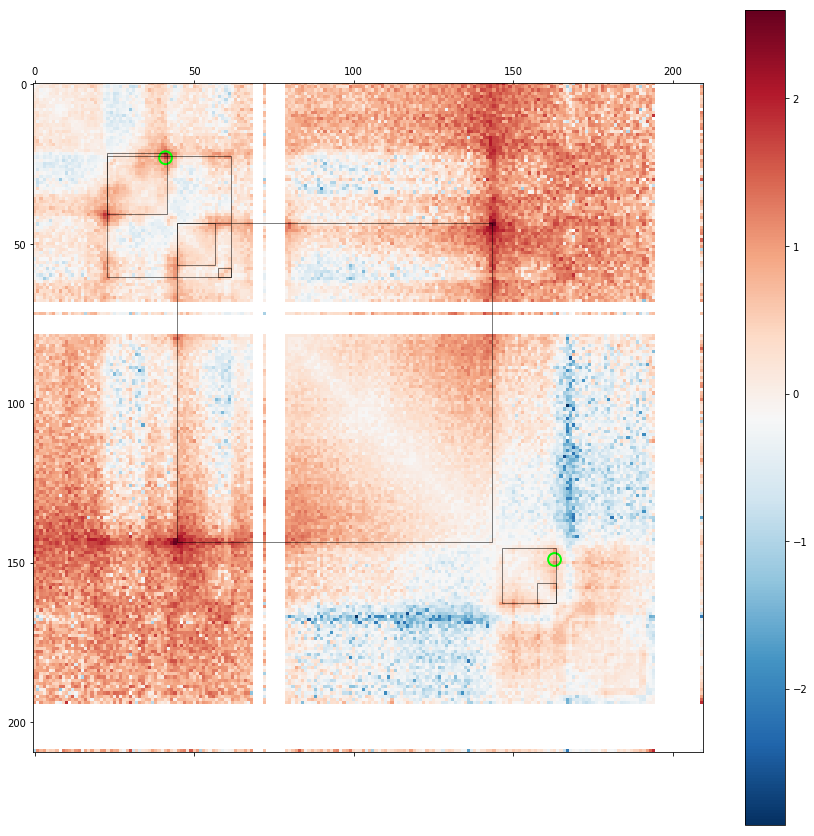

In [11]:
plot_loops_on_hic_matrix(arr_norm_log, resolution, loops, start = 190, end = 400)

### Average loop

In [12]:
def avg_loops(arr):
    '''
        Get average of all loops by extracting each loop and summing them into one. After that divide by loops number
    '''
    loop = loops.iloc[0]
    loop_y_centroid = loop['centroid1']
    loop_x_centroid = loop['centroid2']
    loop_sum = loops_utils.get_loop_with_window(arr, loop_x_centroid, loop_y_centroid)

    for idx in range(1, loops.shape[0]):
        loop_y_centroid = loop['centroid1']
        loop_x_centroid = loop['centroid2']
        loop_window = loops_utils.get_loop_with_window(arr, loop_x_centroid, loop_y_centroid)
        loop_sum = loop_sum + loop_window
        
    loop_avg = loop_sum / loops.shape[0]    
        
    return loop_avg

### Normalized

###### Single loop

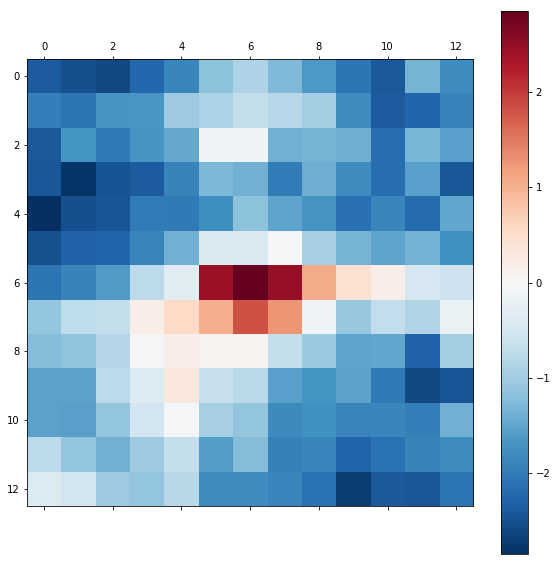

In [13]:
loop = loops.iloc[30]
loop_y_centroid = loop['centroid1']
loop_x_centroid = loop['centroid2']
loop_window = loops_utils.get_loop_with_window(arr_norm, loop_x_centroid, loop_y_centroid)
loops_utils.plot_HiC(loops_utils.z_norm_zero_middle(loop_window), figsize=(10, 10), 
                    name='rao_norm_single_loop')

###### Average loop

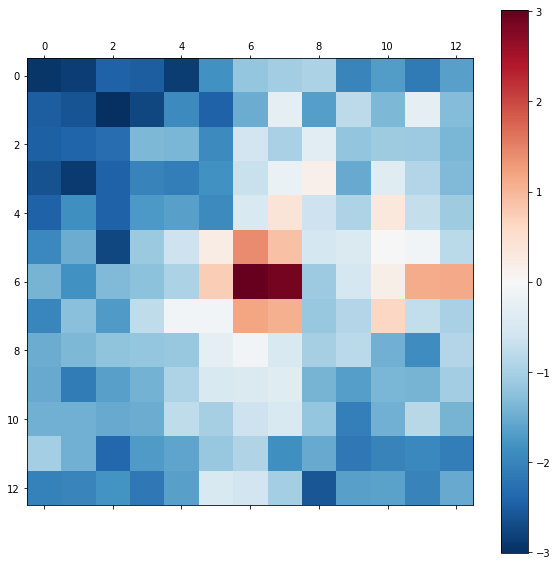

In [14]:
loop_avg = avg_loops(arr_norm)
loops_utils.plot_HiC(loops_utils.z_norm_zero_middle(loop_avg), figsize=(10, 10),
                    name='rao_norm_average_loop')

### Raw data

###### Single loop

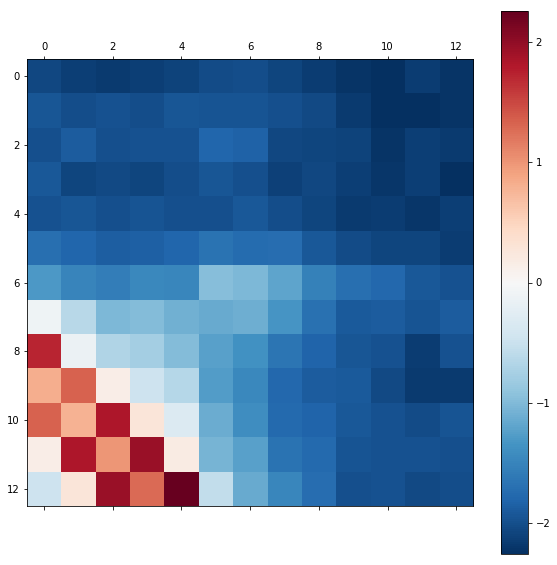

In [15]:
loop = loops.iloc[30]
loop_y_centroid = loop['centroid1']
loop_x_centroid = loop['centroid2']
loop_window = loops_utils.get_loop_with_window(arr, loop_x_centroid, loop_y_centroid)
loops_utils.plot_HiC(loops_utils.z_norm_zero_middle(loop_window), figsize=(10, 10),
                    name='rao_raw_single_loop')

###### Average loop

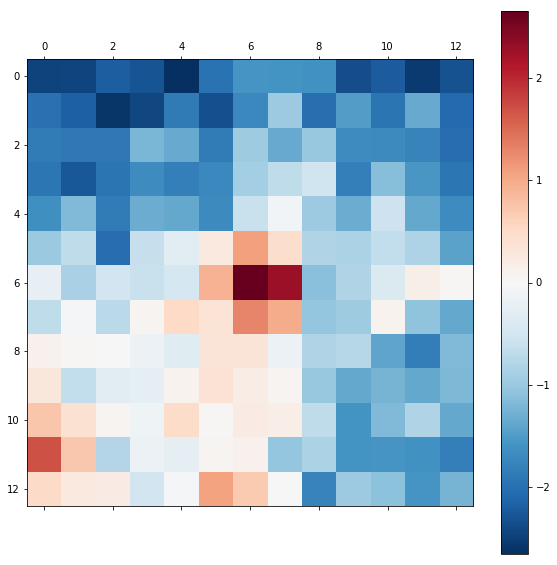

In [16]:
loop_avg = avg_loops(arr)
loops_utils.plot_HiC(loops_utils.z_norm_zero_middle(loop_avg), figsize=(10, 10),
                    name='rao_raw_average_loop')